## Compare rainfall forcing

In [ ]:
# Import the correct packages
import os
from pathlib import Path

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import cartopy.feature as cfeature
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import PowerNorm
from shapely.geometry import MultiLineString


import pandas as pd
import numpy as np
import xarray as xr
import netCDF4 as nc

import hydromt
from hydromt.log import setuplog

In [ ]:
# Read data catalog
path_data_cat = "C:/Code/COMPASS/Workflows/03_data_catalogs/datacatalog_general.yml"
data_catalog = hydromt.data_catalog.DataCatalog(data_libs = path_data_cat)

wflow_region  = "p:/11210471-001-compass/02_Models/sofala/Idai/wflow/staticgeoms/region.geojson"
wflow_basins  = "p:/11210471-001-compass/02_Models/sofala/Idai/wflow/staticgeoms/basins.geojson"

# region of eastern Africa
bbox_big = (29,-27,46,-9)
region = gpd.read_file(wflow_region)
basins = gpd.read_file(wflow_basins)

# time range of the event
start_date = np.datetime64('2019-03-09T00:00') 
end_date = np.datetime64('2019-03-25T06:00') 
time_range = (start_date, end_date)


In [ ]:
# Load raster data for specified region and time range for ERA5
era5_tp = data_catalog.get_rasterdataset(
    data_like = 'era5_hourly_zarr',
    time_tuple = time_range,
    variables = 'precip',
    geom=region,
    buffer=2
)

# and for whole of Mozambique (MZ)
era5_tp_MZ = data_catalog.get_rasterdataset(
    data_like = 'era5_hourly_zarr',
    time_tuple = time_range,
    variables = 'precip',
    bbox=bbox_big,
    buffer=2
)

In [ ]:
# Load raster data for specified region and time range for CHIRPS
chirps_tp = data_catalog.get_rasterdataset(
    data_like = 'chirps',
    time_tuple = time_range,
    variables = 'precip',
    geom=region,
    buffer=2
)

# and for whole of Mozambique (MZ)
chirps_tp_MZ = data_catalog.get_rasterdataset(
    data_like = 'chirps',
    time_tuple = time_range,
    variables = 'precip',
    bbox=bbox_big,
    buffer=2
)

In [ ]:
# Load raster data for specified region and time range for TAMSAT
tamsat_tp = data_catalog.get_rasterdataset(
    data_like = 'TAMSAT_MZ',
    time_tuple = time_range,
    variables = 'precip',
    geom=region,
    buffer=2
)

# and for whole of Mozambique (MZ)
tamsat_tp_MZ = data_catalog.get_rasterdataset(
    data_like = 'TAMSAT_MZ',
    time_tuple = time_range,
    variables = 'precip',
    bbox=bbox_big,
    buffer=2
)

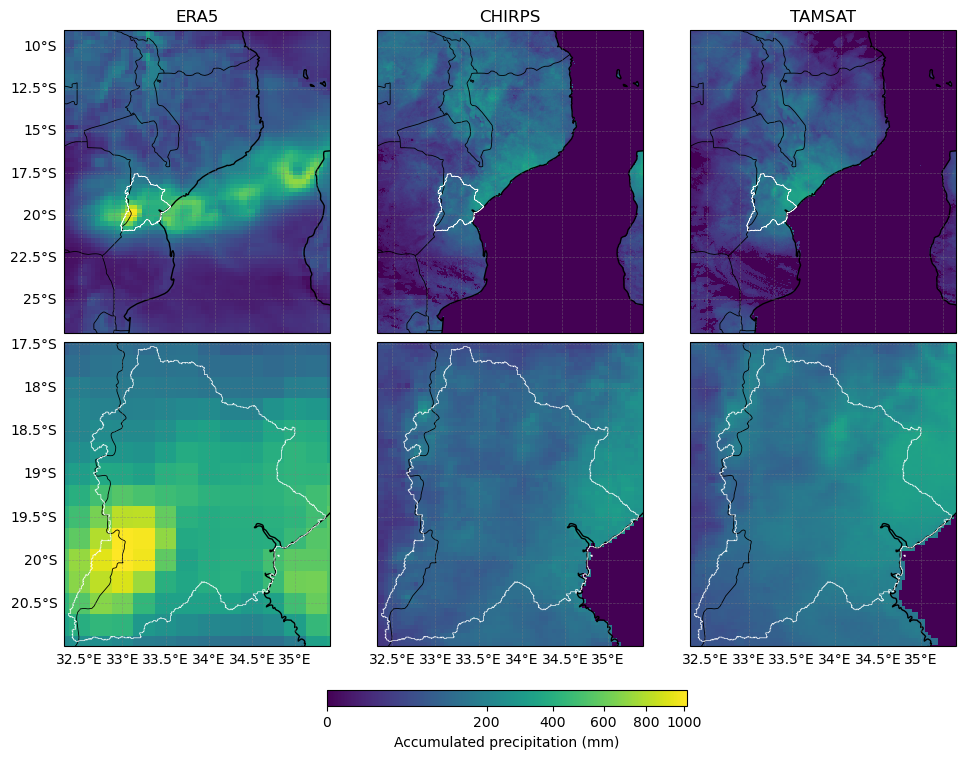

In [ ]:
# Set up subplots
fig, axes = plt.subplots(2, 3, figsize=(12, 8), subplot_kw={"projection": ccrs.PlateCarree()})

# List of datasets and titles
datasets = [
    (era5_tp_MZ, "ERA5"),
    (chirps_tp_MZ, "CHIRPS"),
    (tamsat_tp_MZ, "TAMSAT"),
]

# Sum and determine color limits
accums = []
for data, _ in datasets:
    time_dim = 'time' if 'time' in data.dims else 'valid_time'
    accums.append(data.sum(dim=time_dim))
vmin = min([a.min().compute().item() for a in accums])
vmax = max([a.max().compute().item() for a in accums])
norm = PowerNorm(gamma=0.5, vmin=vmin, vmax=vmax)
cmap = cm.get_cmap("viridis")

# Convert and extract boundary
basins_latlon = basins.to_crs(epsg=4326)
merged_geom = basins_latlon.unary_union
if merged_geom.geom_type == 'Polygon':
    outer_boundary = merged_geom.exterior
elif merged_geom.geom_type == 'MultiPolygon':
    outer_boundary = MultiLineString([poly.exterior for poly in merged_geom.geoms])
else:
    raise ValueError(f"Unexpected geometry type: {merged_geom.geom_type}")

# Get extent
minx, miny, maxx, maxy = region.total_bounds
minx_big, miny_big, maxx_big, maxy_big = bbox_big

# Loop through both rows: top row = large region, bottom = zoomed in
for i, ((data, title), summed) in enumerate(zip(datasets, accums)):
    for row in [0, 1]:  # 0 = whole of MZ, 1 = zoom to region
        ax = axes[row, i]
        im = summed.plot(
            ax=ax,
            transform=ccrs.PlateCarree(),
            cmap=cmap,
            norm=norm,
            add_colorbar=False
        )
        
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS, linewidth=0.6) 
        ax.add_geometries([outer_boundary], crs=ccrs.PlateCarree(),
                          edgecolor='white', facecolor='none', linewidth=0.5)
        if row == 0:
            # Full extent (wider region)
            ax.set_extent([minx_big, maxx_big-1.2, miny_big, maxy_big], crs=ccrs.PlateCarree())
            ax.set_title(f"{title}")
        else:
            ax.set_extent([minx - 0.05, maxx + 0.05, miny - 0.05, maxy + 0.05], crs=ccrs.PlateCarree())
            ax.set_title(f"")

        # Add gridlines with lat/lon labels
        gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False         # You can set this to True if needed
        gl.right_labels = False       # Typically False unless you want labels on the rightmost plots
        gl.bottom_labels = (row == 1) # Only bottom row gets bottom labels
        gl.left_labels = (i == 0)     # Only leftmost plots get y-axis labels
        gl.xlabel_style = {'size': 10}
        gl.ylabel_style = {'size': 10}

# Add colorbar below all subplots
cbar_ax = fig.add_axes([0.36, 0.035, 0.3, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.set_label("Accumulated precipitation (mm)")

# Adjust spacing between rows
plt.subplots_adjust(hspace=0.03, wspace=0.03)
plt.show()
